In [1]:


from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os


# In[2]:


root_folder = os.path.dirname(os.getcwd())
path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_46.npy');
path_to_recording= path.join(root_folder,'data/synthesized/data_46.npy');

sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

waveform_length = 72;
step_size = int(np.round(waveform_length * 0.1))
batch_size = 15000;


# In[3]:


# loads spike detection model
num_classes_detect = 2;
path_to_model_detect = path.join(root_folder, 'models/detect/resnet18_num_classes_2_epoch_22.pt')
model_detect = cnn.resnet18(num_classes=num_classes_detect);
checkpoint = torch.load(path_to_model_detect)
model_detect.load_state_dict(checkpoint['model_state_dict'])
model_detect.to(device);


# In[4]:


# loads re id model
num_classes_re_id = 499;
path_to_model_re_id = path.join(root_folder, 'models/re_id/resnet18_num_classes_499_epoch_74.pt')
model_re_id = cnn.ft_net(class_num = num_classes_re_id);
checkpoint = torch.load(path_to_model_re_id)
model_re_id.load_state_dict(checkpoint['model_state_dict'])
model_re_id.to(device);

max_amplitude_index_per_rec = [];
# In[5]:
for d in range(1, 96):
    path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_'+ str(d)+'.npy');
    path_to_recording= path.join(root_folder,'data/synthesized/data_' + str(d) +'.npy');


    # transforms data for inference
    transform = transforms.Compose([cnn.FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1), cnn.OptimizedZScoreNormalizaton()])
    recording = cnn.Recording(path_to_recording, transform = transform);
    recording_padded = cnn.AddPaddingToRecording(recording, step_size, waveform_length)
    # gets waveform data for each window
    waveform_indices = cnn.GetWaveformIndices(recording_padded, step_size, waveform_length)
    transform = transforms.Compose([cnn.ExtractWaveforms(waveform_indices, waveform_length)])
    waveforms = transform(recording_padded.data);
    normalized_waveforms = waveforms;


    # In[6]:


    ### spike detection pipeline
    # loads data for inference
    dataset_to_infer_detect = cnn.InferenceDataset(normalized_waveforms.to(device));
    data_loader_detect = torch.utils.data.DataLoader(dataset_to_infer_detect, batch_size=batch_size, shuffle=False, num_workers=0);

    #inference for detection 
    result_detect = cnn.Inference(model_detect, data_loader_detect, num_classes_detect)
    treshold = 0.9;
    predictions = cnn.PredictionByTreshold(result_detect, treshold)
    max_amplitude_index = cnn.GetNonOverlappingSpikesMaxAmplitude(recording_padded, predictions, waveform_length, waveforms, waveform_indices)


    # In[7]:


    del dataset_to_infer_detect, data_loader_detect
    torch.cuda.empty_cache()



    # In[8]:

    non_out_of_bound_index = np.where((max_amplitude_index - waveform_length // 2 >= 0) & (max_amplitude_index + waveform_length // 2 < recording.__len__()));
    max_amplitude_index = max_amplitude_index[non_out_of_bound_index];

    max_amplitude_index_per_rec.append(max_amplitude_index);

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch


done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104

done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  ba

done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done

done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
do

done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch


done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  bat

done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  ba

done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done: 

done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  bat

done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  

done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  b

done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  bat

done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
d

done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
d

done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  bat

done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  b

done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  

done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  bat

done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
don

done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  ba

done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  ba

done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6 

torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
d

done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  

done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  ba

done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
d

done:  56  batch
done:  57  batch
done:  58  batch
done:  59  batch
done:  60  batch
done:  61  batch
done:  62  batch
done:  63  batch
done:  64  batch
done:  65  batch
done:  66  batch
done:  67  batch
done:  68  batch
done:  69  batch
done:  70  batch
done:  71  batch
done:  72  batch
done:  73  batch
done:  74  batch
done:  75  batch
done:  76  batch
done:  77  batch
done:  78  batch
done:  79  batch
done:  80  batch
done:  81  batch
done:  82  batch
done:  83  batch
done:  84  batch
done:  85  batch
done:  86  batch
done:  87  batch
done:  88  batch
done:  89  batch
done:  90  batch
done:  91  batch
done:  92  batch
done:  93  batch
done:  94  batch
done:  95  batch
done:  96  batch
done:  97  batch
done:  98  batch
done:  99  batch
done:  100  batch
done:  101  batch
done:  102  batch
done:  103  batch
done:  104  batch
done:  105  batch
done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch


done:  106  batch
done:  107  batch
done:  108  batch
done:  109  batch
done:  110  batch
done:  111  batch
done:  112  batch
done:  113  batch
done:  114  batch
done:  115  batch
done:  116  batch
done:  117  batch
done:  118  batch
done:  119  batch
done:  120  batch
done:  121  batch
done:  122  batch
done:  123  batch
done:  124  batch
done:  125  batch
done:  126  batch
done:  127  batch
done:  128  batch
done:  129  batch
done:  130  batch
done:  131  batch
done:  132  batch
done:  133  batch
done:  134  batch
done:  135  batch
done:  136  batch
done:  137  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
do

In [2]:
max_amplitude_index_per_rec
np.save("detected_data.npy", max_amplitude_index_per_rec)


In [3]:
detected_indices = np.load('detected_data.npy')

In [4]:
detected_indices = detected_indices[45:95]

In [5]:
features_per_rec = [];
for d in range(46, 96):
    path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_'+ str(d)+'.npy');
    path_to_recording= path.join(root_folder,'data/synthesized/data_' + str(d) +'.npy');
    transform = transforms.Compose([cnn.FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1), cnn.OptimizedZScoreNormalizaton()])
    recording = cnn.Recording(path_to_recording, transform = transform);
    max_amplitude_index = torch.unsqueeze(torch.tensor(detected_indices[d - 46]), 0);
    transform = transforms.Compose([cnn.ExtractWaveforms(max_amplitude_index, waveform_length)])
    waveforms_re_id = transform(recording.data);
    #vertical flip
    waveforms_re_id_flipped = waveforms_re_id * -1;
    # data loading for inference
    dataset_to_re_id = cnn.InferenceDataset(waveforms_re_id.to(device));
    data_loader_re_id = torch.utils.data.DataLoader(dataset_to_re_id, batch_size=batch_size, shuffle=False, num_workers=0);
    dataset_to_re_id_flipped = cnn.InferenceDataset(waveforms_re_id_flipped.to(device));
    data_loader_re_id_flipped = torch.utils.data.DataLoader(dataset_to_re_id_flipped, batch_size=batch_size, shuffle=False, num_workers=0);
    feature_map_dims = 128
    features = torch.FloatTensor(0 , 128).zero_();
    model_re_id.model.fc.classifier = nn.Sequential()
    result_re_id = cnn.Inference(model_re_id, data_loader_re_id, feature_map_dims)
    result_re_id_flipped = cnn.Inference(model_re_id, data_loader_re_id_flipped, feature_map_dims)
    features = result_re_id + result_re_id_flipped ;
    temp = torch.norm(features, p=2, dim=1, keepdim=True)
    unit_features = features.div(temp.expand_as(features))
    features_per_rec.append(unit_features.numpy())

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.FloatTensor
done:  0  batch
done:  0  batch
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
torch.cuda.FloatTensor
torch.cuda.Floa

In [6]:
np.linalg.norm(unit_features[1,:])


0.99999994

In [7]:
unit_features[1,:].shape

torch.Size([128])

In [8]:
np.save("feautes.npy", features_per_rec)


In [9]:
detected_features = np.load('feautes.npy')

In [10]:
ground_truth_per_rec = [];
for i in range(45, 95):
    path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_'+ str(i + 1)+'.npy');
    gt = np.load(path_to_ground_truth_data)
    ground_truth_per_rec.append(gt);

In [11]:
d = 0
for i in range(45, 95):
    d = d + 1;

In [12]:
dground_truth_per_rec


50

In [13]:
ground_truth_per_rec

[array([[6.6600000e+02, 8.7550000e+03, 9.3420000e+03, ..., 1.4397258e+07,
         1.4397720e+07, 1.4397831e+07],
        [0.0000000e+00, 0.0000000e+00, 2.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]]),
 array([[1.0700000e+03, 1.6070000e+03, 1.7930000e+03, ..., 1.4397970e+07,
         1.4399215e+07, 1.4399913e+07],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         8.0000000e+00, 9.0000000e+00]]),
 array([[5.1900000e+02, 1.4600000e+03, 2.3600000e+03, ..., 1.4390705e+07,
         1.4392220e+07, 1.4395314e+07],
        [7.0000000e+00, 2.0000000e+00, 0.0000000e+00, ..., 7.0000000e+00,
         6.0000000e+00, 4.0000000e+00]]),
 array([[5.9800000e+02, 1.3480000e+03, 4.0520000e+03, ..., 1.4392743e+07,
         1.4396936e+07, 1.4397328e+07],
        [0.0000000e+00, 9.0000000e+00, 4.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]]),
 array([[5.8300000e+02, 1.8490000e+03, 2.6350000e+03, ..., 1.4398262e+07,
      

In [14]:
found_spike_neuron_index_per_rec = []; # neuron index
is_found_per_rec = [] # index is found or not
for d in range(0, 50):
    gt = ground_truth_per_rec[d]
    max_amplitude_index = detected_indices[d]
    ### detection results
    found_spike_index = [];
    is_found = [];
    for i in range(max_amplitude_index.size):
        spike = max_amplitude_index[i];
        ind =np.where(spike == gt[0, :].astype(int))
        if(len(ind[0]) == 0):
            is_found.append(0);
            found_spike_index.append(0)

        else:
            is_found.append(1)
            found_spike_index.append(int(gt[1, ind[0]]) + 1)
    found_spike_neuron_index_per_rec.append(found_spike_index);
    is_found_per_rec.append(is_found)



In [15]:
tp = np.zeros((50));
fp = np.zeros((50));
total = np.zeros((50));
for i in range(0, 50):
    tp[i] = np.where(np.asarray(is_found_per_rec[i]) == 1)[0].size
    fp[i] = np.where(np.asarray(is_found_per_rec[i]) == 0)[0].size
    total[i] = ground_truth_per_rec[i][1, :].size

In [16]:
single_units_per_rec = np.zeros((50))
for i in range(50):
    single_units_per_rec[i] = np.unique(ground_truth_per_rec[i][1, :]).size - 1

In [43]:
sum(total) - sum(tp)

22985.0

In [44]:
sum(fp)

70754.0

In [39]:

gt_total = 0;
for i in range(50):
    gt_total = gt_total +  ground_truth_per_rec[i][1, :].size
    

In [42]:
gt_total - sum(total)

0.0

In [18]:
avg_per_single_unit_tp = np.zeros((95 // 5))
avg_per_single_unit_fp = np.zeros((95 // 5))
avg_per_single_unit_total = np.zeros((95 // 5))
for i in range(95 // 5):
    indices = np. where(single_units_per_rec  == i + 2)[0];
    avg_per_single_unit_tp[i] = np.sum(tp[ indices]) / indices.size
    avg_per_single_unit_fp[i] = np.sum(fp[ indices]) / indices.size
    avg_per_single_unit_total[i] = np.sum(total[ indices]) / indices.size


In [19]:
np.mean(avg_per_single_unit_fp / (avg_per_single_unit_fp + avg_per_single_unit_tp))

0.1547965249230982

In [20]:
avg_per_single_unit_total


array([ 4456.        ,  4618.        ,  5048.        ,  6892.66666667,
        6253.        ,  6932.        ,  7175.5       ,  7803.        ,
        8137.5       ,  9025.        ,  9992.66666667,  9505.5       ,
       11404.33333333, 11830.        , 11002.        , 13195.66666667,
       13368.33333333, 13828.        , 13800.5       ])

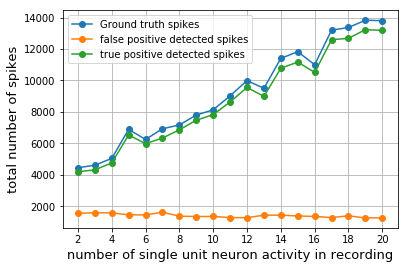

In [30]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

x = np.arange(2, 21)
plt.plot(x, avg_per_single_unit_total, marker='o')

plt.plot(x, avg_per_single_unit_fp, marker='o')

plt.plot(x, avg_per_single_unit_tp, marker='o')

plt.xlabel('xlabel', fontsize=18)
plt.xlabel('number of single unit neuron activity in recording', fontsize=13)
plt.ylabel('total number of spikes', fontsize=13)
ax.legend(labels=["Ground truth spikes","false positive detected spikes", "true positive detected spikes"])
plt.grid()

plt.savefig('detections.jpg')


In [22]:
print(np.sum(avg_per_single_unit_tp) /np.sum(avg_per_single_unit_total))


0.9505855934262044


In [23]:
avg_per_multi_tp = np.zeros((95))
avg_per_multi_unit_fp = np.zeros((95))
avg_per_mutli_unit_total = np.zeros((95))
for i in range(50):
    indices = np.where(np.asarray(found_spike_neuron_index_per_rec[i])  > 1)[0];
    avg_per_multi_tp[i] = indices.size
    avg_per_mutli_unit_total[i] = np.where(np.asarray(ground_truth_per_rec[i][1, :]) > 0)[0].size
    avg_per_multi_unit_fp[i] = avg_per_mutli_unit_total[i] - avg_per_multi_tp[i];


In [24]:
np.where(np.asarray(found_spike_neuron_index_per_rec[i])  > 1)[0].size
np.where(np.asarray(ground_truth_per_rec[i]) > 0)[0].size

22195

In [25]:
ground_truth_per_rec[0][1, :]

array([0., 0., 2., ..., 0., 0., 0.])

In [26]:
np.sum(avg_per_multi_tp) / np.sum(avg_per_mutli_unit_total)

0.9708225146327509

In [27]:
features_per_rec

[array([[ 0.10213609, -0.09339483, -0.06493612, ...,  0.04620364,
         -0.01885863, -0.01387808],
        [ 0.13223483, -0.0833162 , -0.03947622, ...,  0.07097762,
          0.02241331, -0.02385795],
        [ 0.11408833, -0.12572633, -0.00064021, ...,  0.02657954,
         -0.07931306,  0.05384959],
        ...,
        [ 0.02526662, -0.1543704 , -0.05709654, ..., -0.07785428,
          0.00553142,  0.07267396],
        [ 0.0756981 ,  0.05018535,  0.09770156, ..., -0.05158665,
          0.02613286,  0.09191725],
        [-0.01207411, -0.12796795, -0.00718436, ...,  0.04121161,
          0.01476396,  0.09423564]], dtype=float32),
 array([[ 0.01374269, -0.19810793, -0.0225435 , ...,  0.01606363,
          0.07363237,  0.07255527],
        [ 0.00662726, -0.16158524, -0.02988464, ..., -0.02112409,
         -0.03876067,  0.01476952],
        [ 0.06554178,  0.06885131, -0.02036302, ..., -0.00109114,
          0.18095663,  0.07809131],
        ...,
        [ 0.04512379, -0.1271597 , -0.0

In [28]:
feature_list_per_rec = [];
ids_list_per_rec = []


treshold = 0.6;
for k in range(50):
    unit_features = torch.tensor(features_per_rec[k])
    feature_list = torch.unsqueeze(unit_features[0, :], 0).to(device)
    ids_list = torch.tensor([0], dtype=torch.int)
    for i in range(1,unit_features.size()[0]):
        query = torch.unsqueeze(unit_features[i, :], 0).to(device);
        query_raveled = query.view(-1,1);
        score = torch.mm(feature_list, query_raveled);
        max_val, max_ind = torch.max(score, 0);
        # spike is already in list
        if(max_val.item() > treshold):
            ids_list = torch.cat((ids_list, torch.tensor([ids_list[max_ind.item()]], dtype = torch.int)), 0);
        # adds a new spike id
        else:
            new_id = torch.max(ids_list, 0)[0] + 1;
            ids_list = torch.cat((ids_list, torch.tensor([new_id.item()], dtype = torch.int)), 0);

        feature_list = torch.cat((feature_list, query), 0);
    feature_list_per_rec.append(feature_list)
    ids_list_per_rec.append(ids_list)
    max_amplitude_index = detected_indices[d]


In [29]:
    unique_classes, nb_of_occourences = np.unique(spike_classes, return_counts=True);
    print(nb_of_occourences)


NameError: name 'spike_classes' is not defined

In [ ]:
%pdb on

In [ ]:
for k in range(50):
    found_spike_index = np.asarray(found_spike_neuron_index_per_rec[k]);
    ids_list = ids_list_per_rec[k]
    unique_classes, nb_of_occourences = np.unique(ids_list, return_counts=True);
    spike_classes = np.empty((unique_classes.size,),dtype=object)
    print(np.where(found_spike_index == 0)[0].shape)
    for i in range(spike_classes.size):
        spike_classes[i] = [];

    for i in range(ids_list.nelement()):
        index = found_spike_index[i];
        index_re_id = ids_list[i].item()
        spike_classes[index_re_id].append(index)
    classes_size = np.zeros((spike_classes.size), dtype='int')
    for i in range(spike_classes.size):
        spike_classes[i] = np.asarray(spike_classes[i])
        classes_size[i] = spike_classes[i].size;
        
    for i in range(spike_classes.size):
        unique_classes, nb_of_occourences = np.unique(spike_classes[i], return_counts=True);
        if(np.max(nb_of_occourences) / np.sum(nb_of_occourences) < 0.5):
            print(np.max(nb_of_occourences) / np.sum(nb_of_occourences))
            print("max occ: ", np.max(nb_of_occourences), "total: ", np.sum(nb_of_occourences), "id: " , unique_classes[np.argmax(nb_of_occourences)], " % of total: ", np.max(nb_of_occourences) / np.sum(nb_of_occourences))

        



In [ ]:
unique_classes

In [ ]:
d = feature_list_per_rec;
t = ids_list_per_rec

In [ ]:
np.where(np.sort(t[0]) != np.sort(ids_list_per_rec[0]))

In [ ]:
tp_rec = 0;
total_rec = 0;
for k in range(50):
    tp_rec = 0;
    total_rec = 0;
    found_spike_index = np.asarray(found_spike_neuron_index_per_rec[k]);
    ids_list = ids_list_per_rec[k]
    unique_classes, nb_of_occourences = np.unique(ids_list, return_counts=True);
    print(unique_classes)
    print(nb_of_occourences)
    unique_classes, nb_of_occourences = np.unique(found_spike_index, return_counts=True);
    print(unique_classes)
    spike_classes = np.empty((unique_classes.size,),dtype=object)
    for i in range(spike_classes.size):
        spike_classes[i] = [];
    for i in range(found_spike_index.size):
        index = found_spike_index[i];
        index_re_id = ids_list[i]
        if (index == 0):
            spike_classes[index].append(index_re_id.item());
        else:
            spike_classes[index].append(index_re_id.item())
    print('='* 10)
    tp = 0;
    total = 0;
    for i in range(1, spike_classes.size):
        unique_classes, nb_of_occourences = np.unique(spike_classes[i], return_counts=True);
        tp = tp + np.max(nb_of_occourences);
        total = total + np.sum(nb_of_occourences);
        #print("max occ: ", np.max(nb_of_occourences), "total: ", np.sum(nb_of_occourences), "id: ", unique_classes[np.argmax(nb_of_occourences)])
    tp_rec = tp_rec + tp;
    total_rec = total_rec +total;
    print(tp / total)  
    print(total_rec, tp_rec)
print("ddd")
print(tp_rec / total_rec)


In [ ]:
found_spike_index

In [ ]:
tp_rec = 0;
total_rec = 0;
list_tp = np.zeros((50))
list_total = np.zeros((50))
for k in range(50):
    found_spike_index = np.asarray(found_spike_neuron_index_per_rec[k]);
    ids_list = t[k]
    unique_classes, nb_of_occourences = np.unique(ids_list, return_counts=True);
    print(unique_classes)
    unique_classes, nb_of_occourences = np.unique(found_spike_index, return_counts=True);
    print(unique_classes)

    spike_classes = np.empty((unique_classes.size,),dtype=object)
    for i in range(spike_classes.size):
        spike_classes[i] = [];
    for i in range(found_spike_index.size):
        index = found_spike_index[i];
        index_re_id = ids_list[i]
        if (index == 0):
            spike_classes[index].append(0);
        else:
            spike_classes[index].append(index_re_id.item())
    print('='* 10)
    tp = 0;
    total = 0;
    for i in range(1, spike_classes.size):
        unique_classes, nb_of_occourences = np.unique(spike_classes[i], return_counts=True);
        tp = tp + np.max(nb_of_occourences);
        total = total + np.sum(nb_of_occourences);
        print("max occ: ", np.max(nb_of_occourences), "total: ", np.sum(nb_of_occourences), "id: ", unique_classes[np.argmax(nb_of_occourences)])
    
    tp_rec = tp_rec + tp;
    total_rec = total_rec +total;
    print(tp / total)  
    list_tp[k] = (tp)
    list_total[k] = (total)
print(tp_rec / total_rec)


In [ ]:

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

x = np.arange(1, 51)
plt.plot(x, list_tp / list_total * 100, marker='o')

plt.xlabel('xlabel', fontsize=18)
plt.xlabel('recording', fontsize=13)
plt.ylabel('accuracy', fontsize=13)
ax.legend(labels=["Accuracy of each recording"])

plt.savefig('classiification.jpg')


In [ ]:
 list_tp / list_total